# Importing packages 

In [1]:
# Data wrangling 
import pandas as pd 

# Dates
from datetime import datetime

# Iteration tracking
from tqdm import tqdm
import time

# Array math
import numpy as np

# Ploting 
import matplotlib.pyplot as plt

# Xgboost models 
import xgboost as xgb

# Grid search for paramters
from sklearn.model_selection import ParameterGrid

# Reading train data 

In [2]:
d = pd.read_csv('train_data.csv', low_memory=False)

In [3]:
d.dtypes

Store              int64
DayOfWeek          int64
Date              object
Sales              int64
ShopOpen           int64
Promotion          int64
StateHoliday      object
SchoolHoliday      int64
StoreType         object
AssortmentType    object
dtype: object

In [4]:
print(f"Shape of data: {d.shape}")

Shape of data: (1017209, 10)


In [5]:
d.head(10)

,Store,DayOfWeek,Date,Sales,ShopOpen,Promotion,StateHoliday,SchoolHoliday,StoreType,AssortmentType
0,1,5,2015-07-31,5263,1,1,0,1,c,a
1,2,5,2015-07-31,6064,1,1,0,1,a,a
2,3,5,2015-07-31,8314,1,1,0,1,a,a
3,4,5,2015-07-31,13995,1,1,0,1,c,c
4,5,5,2015-07-31,4822,1,1,0,1,a,a
5,6,5,2015-07-31,5651,1,1,0,1,a,a
6,7,5,2015-07-31,15344,1,1,0,1,a,c
7,8,5,2015-07-31,8492,1,1,0,1,a,a
8,9,5,2015-07-31,8565,1,1,0,1,a,c
9,10,5,2015-07-31,7185,1,1,0,1,a,a


# Data preprocesing and feature engineering

In [6]:
# Converting to categorical all the categorical variables
cat_cols = [
    'Store', 
    'DayOfWeek', 
    'ShopOpen', 
    'Promotion', 
    'StateHoliday', 
    'SchoolHoliday', 
    'StoreType', 
    'AssortmentType'
]

d[cat_cols] = d[cat_cols].astype(str)

In [7]:
# Converting the Date column to datetime object
d['Date'] = [datetime.strptime(x, '%Y-%m-%d') for x in tqdm(d['Date'])]

# Getting the day of month 
d['day_of_month'] = [x.day for x in tqdm(d['Date'])]

100%|██████████| 1017209/1017209 [00:00<00:00, 1094704.77it/s]


## Adding the month of the year as a feature 

In [8]:
d['month_year'] = [str(x.month) for x in d['Date']]

In [9]:
d.sample(10)

,Store,DayOfWeek,Date,Sales,ShopOpen,Promotion,StateHoliday,SchoolHoliday,StoreType,AssortmentType,day_of_month,month_year
460597,888,4,2014-05-15,6615,1,0,0,0,d,a,15,5
962145,686,2,2013-02-19,6812,1,1,0,0,a,a,19,2
69841,712,6,2015-05-30,5255,1,0,0,0,a,a,30,5
66294,510,2,2015-06-02,11783,1,1,0,0,a,c,2,6
392152,676,5,2014-07-18,8770,1,1,0,0,b,b,18,7
211179,445,5,2015-01-23,6065,1,0,0,0,a,a,23,1
892907,578,1,2013-04-22,8664,1,1,0,0,d,a,22,4
289781,126,2,2014-11-04,7895,1,1,0,0,d,a,4,11
17783,1059,4,2015-07-16,10045,1,1,0,1,c,a,16,7
810341,522,5,2013-07-05,8773,1,1,0,0,d,c,5,7


## Unique categorical value list 

In [10]:
d[cat_cols + ['day_of_month', 'month_year']].nunique()

Store             1115
DayOfWeek            7
ShopOpen             2
Promotion            2
StateHoliday         4
SchoolHoliday        2
StoreType            4
AssortmentType       3
day_of_month        31
month_year          12
dtype: int64

## Distribution of the Y variable 

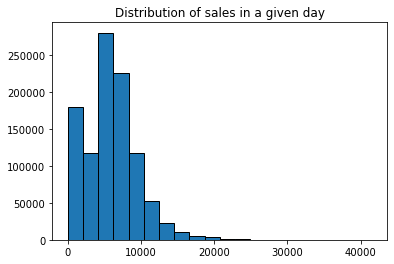

In [11]:
plt.hist(d['Sales'], edgecolor='black', bins=20)
plt.title('Distribution of sales in a given day')
plt.show()

In [12]:
# Descriptive stats
round(d['Sales'].describe(), 2)

count    1017209.00
mean        5773.82
std         3849.93
min            0.00
25%         3727.00
50%         5744.00
75%         7856.00
max        41551.00
Name: Sales, dtype: float64

# Feature list 

In [13]:
features = [
    "Store",
    'DayOfWeek', 
    'Promotion', 
    'StateHoliday', 
    'SchoolHoliday', 
    'StoreType', 
    'AssortmentType',
    'month_year',
    'day_of_month'
]

# Creating the final X and Y matrices 

In [14]:
X = pd.get_dummies(d[features])
Y = d['Sales']

In [15]:
print(f"Shape of X matrix: {X.shape}")
print(f"Shape of Y matrix: {Y.shape}")

Shape of X matrix: (1017209, 1150)
Shape of Y matrix: (1017209,)


# CPU and GPU speeds vs row count

In [16]:
# Defining the dictionaries
cpu_dict = {
    'objective': 'reg:squarederror'
}

gpu_dict = {
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist'
}

# Number of rows to train on 
nrows = [
    10, 
    100, 
    200, 
    3000, 
    5000, 
    10000, 
    20000, 
    50000, 
    100000, 
    300000
]
cpu_speeds = []
gpu_speeds = []

for nrow in nrows: 
    # Sampling random rows 
    sample = d.sample(nrow)
    
    # Creating X and Y 
    X = pd.get_dummies(sample[features])
    Y = sample['Sales']
    
    # Initiating the model objects
    cpu = xgb.XGBRegressor(**cpu_dict)
    gpu = xgb.XGBRegressor(**gpu_dict)
    
    # Training on cpu 
    start = time.time()
    cpu.fit(X, Y)
    cpu_speed = time.time() - start
    
    # Training on gpu
    start = time.time()
    gpu.fit(X, Y)
    gpu_speed = time.time() - start
    
    # Appending the speed results 
    cpu_speeds.append(cpu_speed)
    gpu_speeds.append(gpu_speed)

# Creating a dataframe 
speeds = pd.DataFrame({
    'nrows': nrows,
    'cpu_speeds': cpu_speeds,
    'gpu_speeds': gpu_speeds
})

speeds['difference'] = speeds['cpu_speeds'] - speeds['gpu_speeds'] 

In [17]:
# Creating a dataframe 
speeds = pd.DataFrame({
    'nrows': nrows,
    'cpu_speeds': cpu_speeds,
    'gpu_speeds': gpu_speeds
})

speeds['difference'] = speeds['cpu_speeds'] - speeds['gpu_speeds'] 

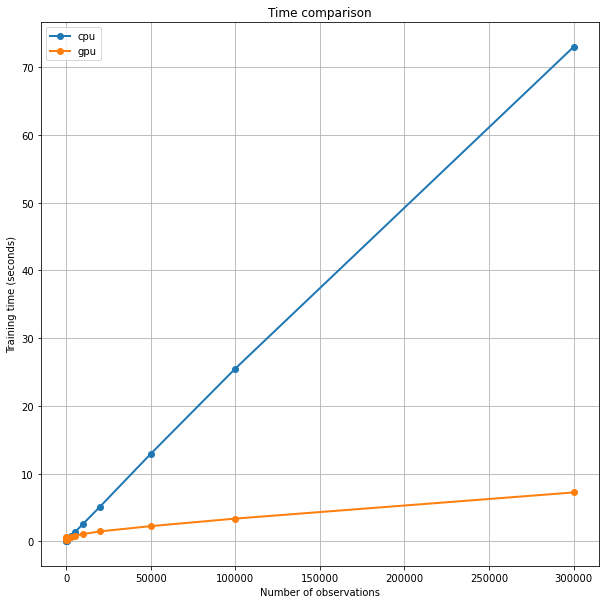

In [18]:
plt.figure(figsize=(10, 10))
plt.plot(nrows, cpu_speeds, '-o', label='cpu', linewidth=2)
plt.plot(nrows, gpu_speeds, '-o', label='gpu', linewidth=2)
plt.xlabel('Number of observations')
plt.ylabel('Training time (seconds)')
plt.title('Time comparison')
plt.legend()
plt.grid()
plt.show()

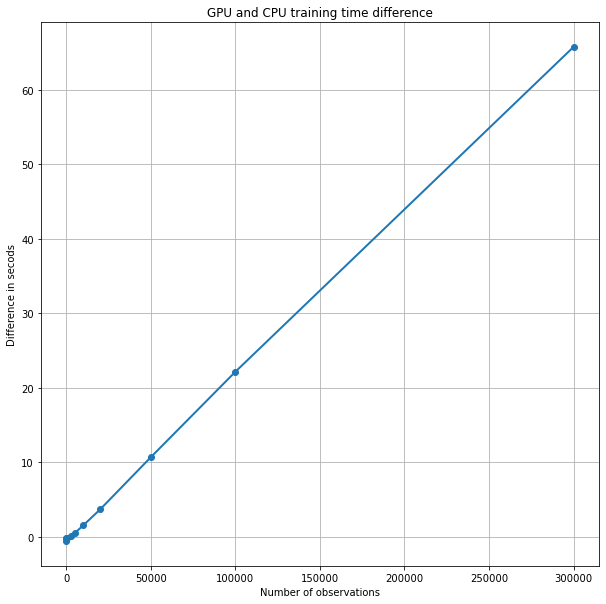

In [19]:
plt.figure(figsize=(10, 10))
plt.plot(speeds['nrows'], speeds['difference'], '-o', linewidth=2)
plt.xlabel('Number of observations')
plt.ylabel('Difference in secods')
plt.title('GPU and CPU training time difference')
plt.grid()
plt.show()

In [20]:
speeds

,nrows,cpu_speeds,gpu_speeds,difference
0,10,0.058012,0.639144,-0.581132
1,100,0.035006,0.201051,-0.166045
2,200,0.046009,0.231053,-0.185045
3,3000,0.802180,0.667149,0.135030
4,5000,1.323302,0.823191,0.500111
5,10000,2.599583,1.078243,1.521340
6,20000,5.130873,1.464183,3.666691
7,50000,12.927393,2.245736,10.681657
8,100000,25.503308,3.354919,22.148389
9,300000,72.961866,7.213613,65.748253


# Speed vs hp values

In [124]:
# Defining the grid of parameters 
n_estimators = [30, 100, 200, 300, 600, 900]
max_depth = [4, 6, 8, 12, 14, 16]

# Number of rows to test on 
nrows = 30000

# Creating a dictionary
gpu_dict = {
    'objective': ['reg:squarederror'], 
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'tree_method': ['gpu_hist']
}

cpu_dict = {
    'objective': ['reg:squarederror'], 
    'n_estimators': n_estimators,
    'max_depth': max_depth
}

# Creating the grid of hyper parameters 
gpu_hp = ParameterGrid(gpu_dict)
cpu_hp = ParameterGrid(cpu_dict)

# Getting the random subset of data 
subset = d.sample(nrows)

In [125]:
# Iterating through all hte hyper parameters: 
gpu_speeds = []
for params in gpu_hp:
    # Creating X and Y 
    X = pd.get_dummies(subset[features])
    Y = subset['Sales']
    
    # Initiating the model objects
    gpu = xgb.XGBRegressor(**params)
    
    # Training on cpu 
    start = time.time()
    gpu.fit(X, Y)
    gpu_speed = time.time() - start
    
    gpu_speeds.append(gpu_speed)

In [126]:
# Iterating through all hte hyper parameters: 
cpu_speeds = []
for params in cpu_hp:
    # Creating X and Y 
    X = pd.get_dummies(subset[features])
    Y = subset['Sales']
    
    # Initiating the model objects
    cpu = xgb.XGBRegressor(**params)
    
    # Training on cpu 
    start = time.time()
    cpu.fit(X, Y)
    cpu_speed = time.time() - start
    
    cpu_speeds.append(cpu_speed)

In [127]:
# Creating the speed frame 
speeds = pd.DataFrame({
    'n_estimators': [x.get('n_estimators') for x in list(cpu_hp)],
    'max_depth': [x.get('max_depth') for x in list(cpu_hp)],
    'cpu_speed': cpu_speeds,
    'gpu_speed': gpu_speeds
})

# Diff of speed between GPU and CPU
speeds['diff'] = speeds['cpu_speed'] - speeds['gpu_speed']

In [148]:
speeds.sort_values('diff').tail(10)

,n_estimators,max_depth,cpu_speed,gpu_speed,diff
16,600,8,54.034929,15.422919,38.612010
5,900,4,46.151239,6.878170,39.273069
22,600,12,77.520987,32.522436,44.998551
28,600,14,89.254875,43.211544,46.043331
34,600,16,100.829242,53.805374,47.023869
11,900,6,63.503949,13.482705,50.021244
17,900,8,80.873741,24.142909,56.730832
23,900,12,116.523931,51.444740,65.079191
29,900,14,133.788477,68.634349,65.154128
35,900,16,151.523745,86.301038,65.222707


## Aproximating the difference in speeds based on hp

In [129]:
X, Y = np.meshgrid(n_estimators, max_depth)

In [130]:
Z = speeds['diff'].values
Z = np.array(Z).reshape((len(n_estimators), len(max_depth)))

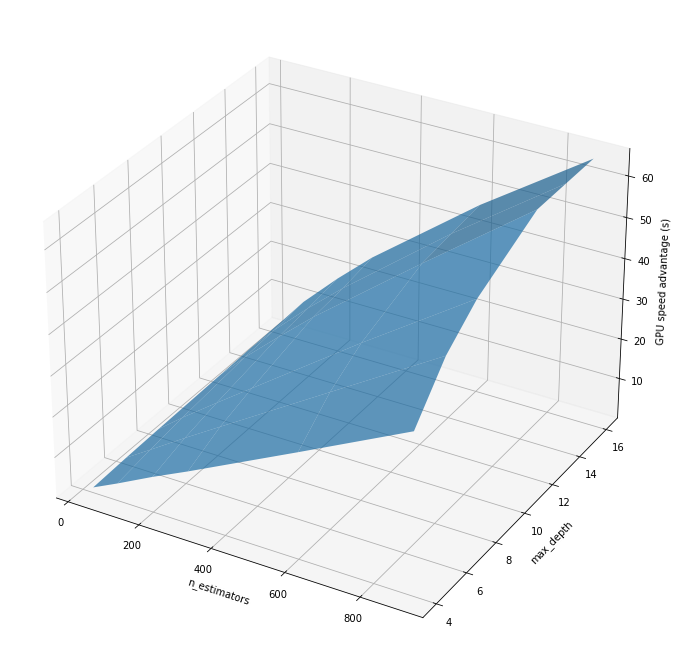

In [146]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
#ax.view_init(45, 45)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, edgecolor='none', alpha=0.7)
ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_zlabel('GPU speed advantage (s)')
plt.show()